# Step - 1

## Importing Required Data Sets and Libraries
- Pandas
- Numpy
- Matplotlib
- seaborn
- sklearn
- PIL
- keras
- tensorflow


In [1]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Diabetic Retinopathy')

Mounted at /content/drive


In [3]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('./train'):
  train_class = os.listdir(os.path.join('train', i))
  for j in train_class:
    img = os.path.join('train', i, j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))


Number of train images : 3663 



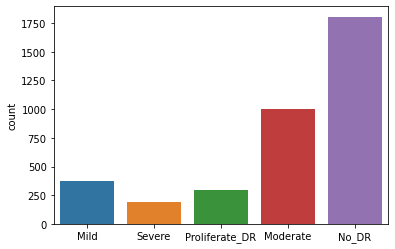

In [4]:
sns.countplot(label)

# Step - 2

## PERFORM DATA EXPLORATION AND DATA VISUALIZATION

In [5]:
# Visualize 5 images for each class in the dataset

fig, axs = plt.subplots(5, 5, figsize = (20, 20))
count = 0
for i in os.listdir('./train'):
  # get the list of images in a given class
  train_class = os.listdir(os.path.join('train', i))
  # plot 5 images per class
  for j in range(5):
    img = os.path.join('train', i, train_class[j])
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1

fig.tight_layout()


Output hidden; open in https://colab.research.google.com to view.

In [6]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
for i in os.listdir('./train'):
  train_class = os.listdir(os.path.join('train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Mild = 370 

Number of images in Severe = 193 

Number of images in Proliferate_DR = 295 

Number of images in Moderate = 1000 

Number of images in No_DR = 1805 



In [7]:
retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df

,Image,Labels
0,train/Mild/cf0575534cec.png,Mild
1,train/Mild/f72ef9ceeaa8.png,Mild
2,train/Mild/e55188915f9d.png,Mild
3,train/Mild/f47a2a4a0411.png,Mild
4,train/Mild/fb6b8200b7f8.png,Mild
...,...,...
3658,train/No_DR/64ac539f58cb.png,No_DR
3659,train/No_DR/8e2a3978c244.png,No_DR
3660,train/No_DR/511fd66b2df8.png,No_DR
3661,train/No_DR/a384e688e228.png,No_DR


<function matplotlib.pyplot.show>

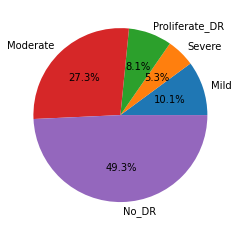

In [8]:
No_images_per_class
Class_name
fig1, ax1 = plt.subplots()
ax1.pie(No_images_per_class, labels = Class_name, autopct = '%1.1f%%')
plt.show

# Step - 3

## PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR



In [9]:
# Shuffle the data and split it into training and testing
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.2)

In [10]:
# Create run-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal flip
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        validation_split = 0.2, 
        horizontal_flip=True)

# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
# Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 2344 validated image filenames belonging to 5 classes.
Found 586 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


# Step - 4
## BUILD RES-BLOCK BASED DEEP LEARNING MODEL

In [12]:
def res_block(X, filter, stage):
  
  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

**RESNET - 18 block**

In [13]:

input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# # 5- stage

# X = res_block(X, filter= [512,512,2048], stage= 5)

#Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

#Final layer

X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

# Step - 5
## COMPILE AND TRAIN DEEP LEARNING MODEL

In [14]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])


In [15]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', verbose=1, patience=15)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="adam_patience_15.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = 2, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/2
73/73 [==============================] - 656s 9s/step - loss: 3.5067 - accuracy: 0.5321 - val_loss: 1.8806 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 1.88061, saving model to adam_patience_15.hdf5
Epoch 2/2
73/73 [==============================] - 44s 600ms/step - loss: 0.8846 - accuracy: 0.6901 - val_loss: 1.7195 - val_accuracy: 0.1042

Epoch 00002: val_loss improved from 1.88061 to 1.71947, saving model to adam_patience_15.hdf5


In [ ]:
## Training Loss

plt.plot(history.history['loss'], label='training loss')
plt.title('Training Loss')
plt.legend(['Training Loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
## Train accuracy

plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.legend(['Training Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
## Validation Loss

plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.legend(['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
## Validation accuracy

plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.legend(['val_ccuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Step - 6
## ASSESS THE PERFORMANCE OF THE TRAINED MODEL

In [16]:
model.load_weights("retina_weights.hdf5")

In [17]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

22/22 [==============================] - 291s 12s/step - loss: 0.5031 - accuracy: 0.8423
Accuracy Test : 0.8423295617103577


In [18]:
# Assigning label names to the corresponding indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3:'Proliferate_DR', 4: 'Severe'}

In [19]:
# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


In [20]:
# Getting the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.8417462482946794


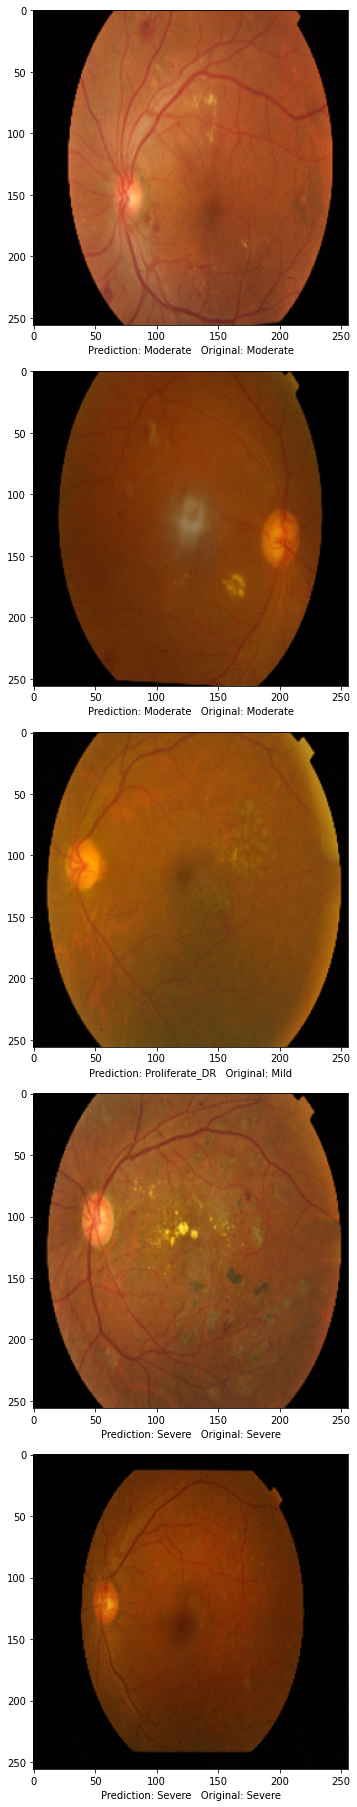

In [21]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(5):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [22]:
# Print out the classification report
print(classification_report(np.asarray(original), np.asarray(prediction)))

                precision    recall  f1-score   support

          Mild       0.83      0.56      0.67        85
      Moderate       0.74      0.86      0.79       212
         No_DR       0.95      0.97      0.96       337
Proliferate_DR       0.67      0.65      0.66        54
        Severe       0.81      0.56      0.66        45

      accuracy                           0.84       733
     macro avg       0.80      0.72      0.75       733
  weighted avg       0.84      0.84      0.84       733



Text(0.5, 1.0, 'Confusion_matrix')

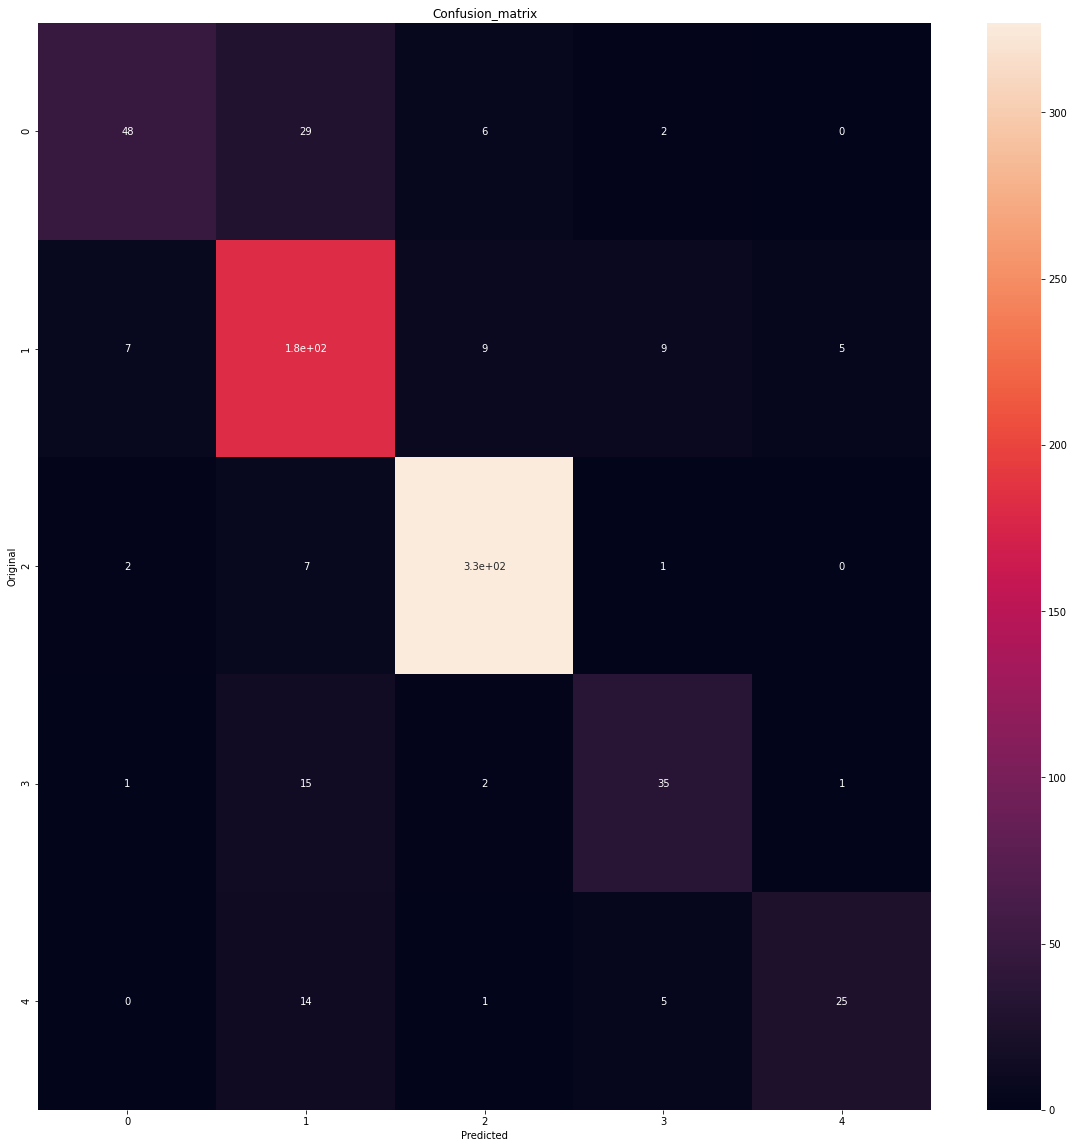

In [23]:

# plot the confusion matrix
plt.figure(figsize = (20,20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

# Other model analysis - adam with patience = 15

In [ ]:
model.load_weights("retina_weights.hdf5")

In [ ]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

In [ ]:
# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


In [ ]:
# Getting the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

In [ ]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(5):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()